In [1]:
import os
from PIL import Image
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import sys 

In [2]:
test_dir = r"./RandomTest/"

In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
    
def circle_crop(img, sigmaX):   
    #Create circular crop around image centre
    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [4]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (200,200))
    return img

In [5]:
def convertJpgToPng(path, outPath, imageName):
    c = 1
    directory = path
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            im = Image.open(directory + filename)
            name = imageName +str(c)+'.png'
            im.save(outPath + name)
            c+=1
            continue
        else:
            continue

In [6]:
def convertImages(sourcePath,destPath,dName):
    i = 1
    for image in os.listdir(sourcePath):
        if(str(image) == ".DS_Store"):
            continue
        img = cv2.imread(sourcePath + str(image))
        img_t = circle_crop(img,sigmaX = 30)
        cv2.imwrite(destPath + str(image) + ".png",img_t)
        print(destPath + dName + "_" + str(i) + ".png")
        i += 1

In [7]:
os.mkdir("./TestImages")
convertImages(r"./RandomTest/",r"./TestImages/","Test")

./TestImages/Test_1.png
./TestImages/Test_2.png
./TestImages/Test_3.png
./TestImages/Test_4.png
./TestImages/Test_5.png
./TestImages/Test_6.png
./TestImages/Test_7.png
./TestImages/Test_8.png
./TestImages/Test_9.png
./TestImages/Test_10.png
./TestImages/Test_11.png
./TestImages/Test_12.png
./TestImages/Test_13.png


In [8]:
model = tf.keras.models.load_model(r"./Models/ResNet50.h5")


2022-04-30 14:57:46.289957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-04-30 14:57:50.272688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Healthy_80.png.png 3


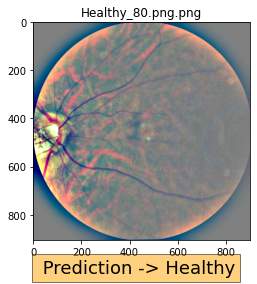

Healthy_81.png.png 3


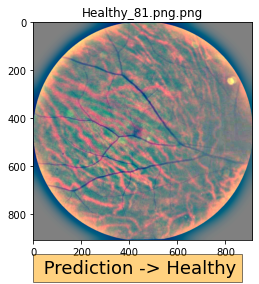

8.png.png 0


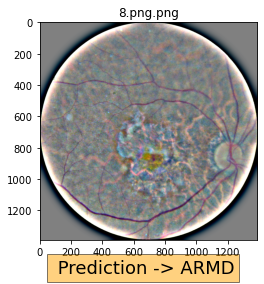

Healthy_82.png.png 3


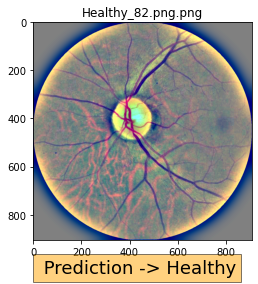

G-86.PNG.png 2


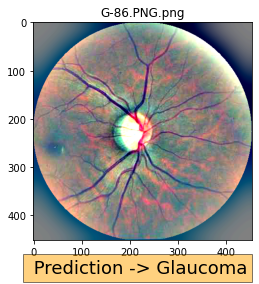

image116.png.png 3


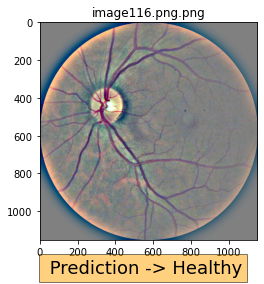

G-87.PNG.png 2


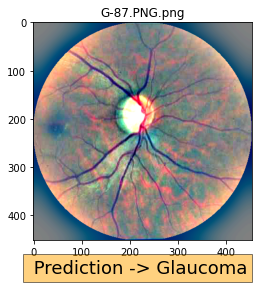

image117.png.png 1


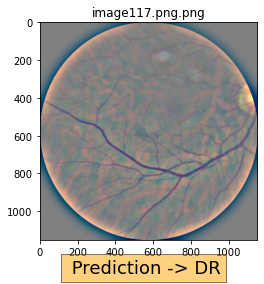

Healthy_79.png.png 3


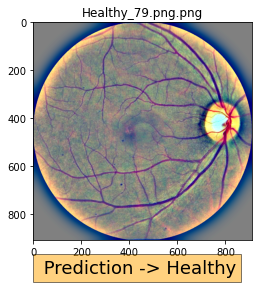

6.png.png 0


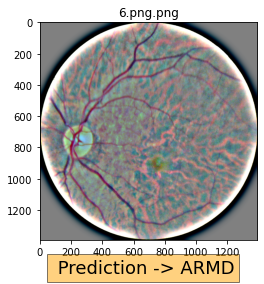

image115.png.png 1


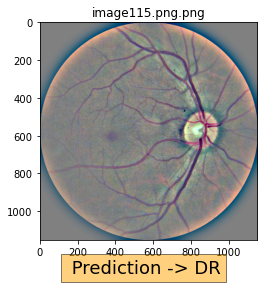

G-85.PNG.png 2


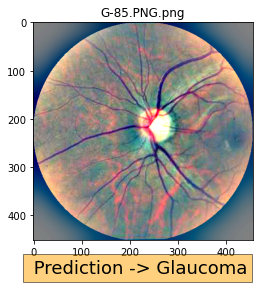

7.png.png 0


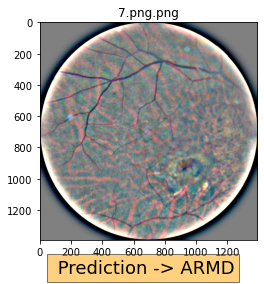

['Healthy', 'Healthy', 'ARMD', 'Healthy', 'Glaucoma', 'Healthy', 'Glaucoma', 'DR', 'Healthy', 'ARMD', 'DR', 'Glaucoma', 'ARMD']


In [9]:
predictions = None
correctPredictions = 0
incorrectPredictions = 0
totalTestImages = 0
imageArray = []
predictionLabels = []

for image in os.listdir(r"./TestImages/"):
    original = load_img(r"./TestImages/" + str(image), target_size = (224, 224))
    numpy_image = img_to_array(original) 
    image_batch = np.expand_dims(numpy_image, axis = 0)
    processed_image = tf.keras.applications.resnet50.preprocess_input(image_batch.copy()) 
    predictions = model.predict(processed_image) 
    
    
    index = np.argmax(predictions[0])
    print(str(image) + " " + str(index))
    
    predictionLabel = ""
    if(index == 0):
        predictionLabel = "ARMD"
    elif(index == 1):
        predictionLabel = "DR"
    elif(index == 2):
        predictionLabel = "Glaucoma"
    else:
        predictionLabel = "Healthy"
        
    
    img = cv2.imread(r"./TestImages/" + str(image))
    imageArray.append(img)
    plt.imshow(img)
    plt.title(str(image))
    plt.figtext(0.5, 0.01, " Prediction -> " + predictionLabel, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.show()
    

    predictionLabels.append(predictionLabel)
    totalTestImages += 1

    
print(predictionLabels)

    
   

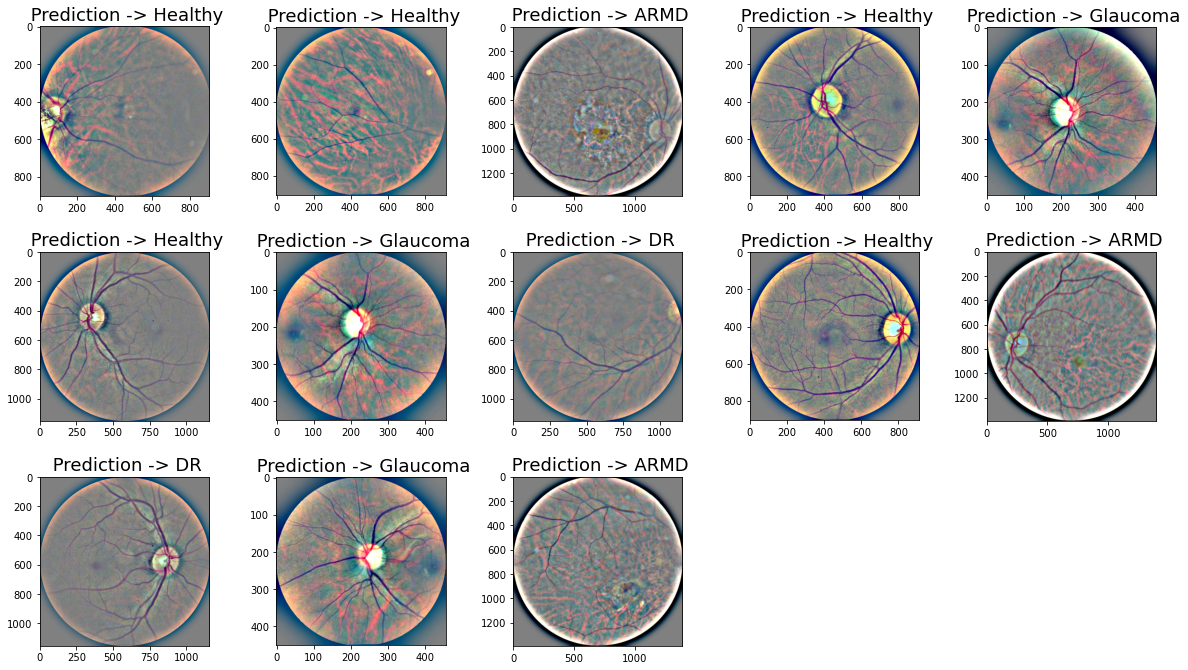

In [10]:
fig = plt.figure(figsize=(20,20))


for i in range(len(imageArray)):
    plt.subplot(5,5,i+1)
    plt.imshow(imageArray[i])
    plt.title(" Prediction -> " + predictionLabels[i], fontsize=18)

plt.subplots_adjust(hspace=0.2, wspace=0.4)
plt.show()